# Bain Strategic Challenge
#### Part two

Construct a complete strategic plan to meet the client's goal of reducing CO2e emissions from deforestation and agrobusiness in the south american Rainforests, specifically in the state of Pará, Brazil.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Initial analysis of new data

For this new step in the process, our team has received some more data, which will be crucial in constructing the analysis our client needs.

In [2]:
# Load new datasets
df_mic = pd.read_excel("City to microregion.xlsx")
df_hist = pd.read_excel("Historical deforestation rate.xlsx")
df_val = pd.read_excel("Value of agribusiness production.xlsx")


# Load previous dataset as well
# Important to use utf-8, as 'açaí' will need a better encoding than default ascii
with open('../historical-database.csv', 'r', encoding='utf-8') as f:
    data = f.read()

data = data.split('\n')
# Separating columns manually
columns = data[0]
data = data[1:-1]
# Remove ending comma, then split by semi-colon
columns = columns[:-1].split(';')

# Transform dates
def date_handler(date: pd.Timestamp):
    return date.year - 1985

# Retransform dates back to pd.Timestamp
def date_reverse(date: int) -> pd.Timestamp:
    return pd.Timestamp(date + 1985, 1, 1)

# Simple example to check that date encoding is working
# sample_date = pd.Timestamp(2015, 1, 1)
# cvt_date = date_handler(sample_date)
# print(f'{sample_date=}\n{cvt_date=}\n{date_reverse(cvt_date)=}')

def process_line(line: str) -> list:
    entries = line.split(';')
    if ',' in entries[-1] and len(entries[-1])>1:
        entries[-1] = float(entries[-1].replace(',','.',-1))
    elif len(entries[-1]) <= 1:
        entries[-1] = None
    else:
        entries[-1] = float(entries[-1])
    # Convert to python-friendly date format.
    entries[0] = datetime.datetime.strptime(entries[0],"%d/%m/%Y")
    return entries

data = list(map(process_line, data))
df_orig = pd.DataFrame(data=data, columns=columns)
# df_orig['year'] = df_orig['year'].apply(date_handler)
# df_orig = df_orig.drop(df_orig[df_orig['year']<0].index, axis = 0)
type_dict = [(val, tip) for tip, val in df_orig[['product_type', 'product']].value_counts().index.to_list() if val != "Others"]
type_dict.append(('Permanent-other', 'permanent'))
type_dict.append(('Temporary-other', 'temporary'))
type_dict = {prod: tip for prod, tip in type_dict}
df_orig.loc[(df_orig['product_type'] == "permanent") & (df_orig['product'] == 'Others'), 'product'] = 'Permanent-other'
df_orig.loc[(df_orig['product_type'] == "temporary") & (df_orig['product'] == 'Others'), 'product'] = 'Temporary-other'
df_orig = df_orig.drop('product_type', axis=1)
df = df_orig.copy(deep=True)
df_orig;

d:\Python\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
d:\Python\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
d:\Python\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## Combining data

The new data comes in several different tables, and must be combined by matching values that uniquely identify the data in question (most often a unique city code).


In [3]:
# Calculate the mean deforestation for the three years in question, as requested
df_hist["Deforest_Mean"] = df_hist[['Deforestation area 2017 (Km2)', 'Deforestation area 2018 (Km2)', 'Deforestation area 2019 (Km2)']].sum(axis=1)*(1/3)
df_hist["Deforest_Rate"] = df_hist["Deforest_Mean"]/df_hist['Total city area (Km2)']
df_hist = df_hist.drop(['Deforestation area 2017 (Km2)', 'Deforestation area 2018 (Km2)', 'Deforestation area 2019 (Km2)'], axis=1)

# Merge microregions of each city with deforestation data
df_mic_hist = df_mic.merge(df_hist, on=['City ID_CodIbge', 'City'], how='right')

# Group average deforestation by mciroregion
df_avg_by_mic = df_mic_hist[['Microregion','Total city area (Km2)', 'Deforest_Rate']].groupby('Microregion').sum().reset_index().drop('Total city area (Km2)', axis=1)

# Group microregions on original dataset, to get destinated_area for each product by microregion
df_mic_prod_area_by_year = df_mic.merge(df_orig, on='city_code', how='right')[['year', 'Microregion', 'product', 'destinated_area']].groupby(['year', 'Microregion', 'product']).sum().reset_index()

# Separate latest year only (2017)
df_mic_prod_area_by_year = df_mic_prod_area_by_year.loc[df_mic_prod_area_by_year['year'] == '2017-01-01'].reset_index().drop('index',axis=1)
df_mic_prod_area_by_year = df_mic_prod_area_by_year.rename({'product':'Product'}, axis=1)

# Merge microregions and value produced by each product
df_mic_prod_value_by_year = df_mic.merge(df_val, on='City ID_CodIbge', how='right')[['Microregion', 'Product', 'Production value (R$ thousands)']].groupby(['Microregion', 'Product']).sum().reset_index()

# Final merge, create dataframe with all necessary columns, except productivity
val_by_area = df_mic_prod_value_by_year.merge(df_mic_prod_area_by_year, on=['Microregion', 'Product'], how = 'outer')

# Add productivity through simple calculations.
val_by_area = val_by_area.dropna(axis=0).drop('year',axis=1)
val_by_area.loc[val_by_area['destinated_area'] == 0, 'Production value (R$ thousands)'] = 0
val_by_area.loc[val_by_area['destinated_area'] == 0, 'destinated_area'] = 1
val_by_area['Productivity'] = val_by_area['Production value (R$ thousands)']/val_by_area['destinated_area']
val_by_area = val_by_area.drop(['Production value (R$ thousands)'], axis=1)


In [4]:
df_avg_productivity = df_avg_by_mic.merge(val_by_area, on = 'Microregion', how='left')

def apply_labels(x):
    if x in ['Livestock', 'Soy']: 
        return 5    
    elif x in ['Sorghum', 'Corn']: 
        return 4 
    elif x in ['Beans', 'Cassava', 'Rice']: 
        return 3
    elif x in ['Palm oil', 'Açaí', 'Cocoa']:
        return 1
    else: 
        return 2

# :(
df_avg_productivity['Ranking'] = df_avg_productivity['Product'].apply(apply_labels)
df_avg_productivity.head(3)

,Microregion,Deforest_Rate,Product,destinated_area,Productivity,Ranking
0,Almeirim,0.002108,Açaí,378.0,20.261905,1
1,Almeirim,0.002108,Beans,105.0,1.323810,3
2,Almeirim,0.002108,Cassava,580.0,5.727586,3


At this point, all the necessary information that was requested has been aggregated and cleaned as best as possible. Now, all that needs to be done is to normalize them from 0 to 10 (as requested), and then calculate the score using the supplied weight matrix.

# Normalizing columns and calculate score

Priorization Matrix

In [5]:
# Normalize to 0-1 (subtract minimum, divide by maximum) then multiply by 10
df_avg_productivity['Deforest_Rate'] = (df_avg_productivity['Deforest_Rate']-df_avg_productivity['Deforest_Rate'].min())/df_avg_productivity['Deforest_Rate'].max()*10
df_avg_productivity['destinated_area'] = (df_avg_productivity['destinated_area']-df_avg_productivity['destinated_area'].min())/df_avg_productivity['destinated_area'].max()*10
df_avg_productivity['Productivity'] = (df_avg_productivity['Productivity']-df_avg_productivity['Productivity'].min())/df_avg_productivity['Productivity'].max()*10
df_avg_productivity['Ranking'] = (df_avg_productivity['Ranking']-df_avg_productivity['Ranking'].min())/df_avg_productivity['Ranking'].max()*10
df_avg_productivity.describe()

,Deforest_Rate,destinated_area,Productivity,Ranking
count,220.000000,220.000000,220.000000,220.000000
mean,1.819090,0.345938,0.233018,4.000000
std,2.141168,1.306543,0.724511,2.973244
min,0.000000,0.000000,0.000000,0.000000
25%,0.527050,0.000000,0.000000,0.000000
50%,1.004050,0.002162,0.071554,4.000000
75%,2.490429,0.035480,0.228074,6.000000
max,9.947457,9.999997,10.000000,8.000000


In [6]:
# Weight matrix
weights = {
'Deforest_Rate' : 0.25,
'destinated_area': 0.4,
'Productivity': 0.1,
'Ranking': 0.25
}

# Aggregate columns by sum of values*weight
s = np.zeros(shape=(df_avg_productivity.shape[0],))
for k, v in weights.items():
    s += df_avg_productivity[k]*v

Now that the score has been fully calculated for each available pair of microregion-product, we order by it and gather critical data points.

In [14]:
# Store and show result
df_avg_productivity['Score'] = s
df_avg_productivity.sort_values('Score', ascending=False).head(1)

,Microregion,Deforest_Rate,Product,destinated_area,Productivity,Ranking,Score
15,Altamira,9.947457,Livestock,8.103128,0.152626,8.0,7.743378


In [15]:
# Remove previously selected values
df_no_altamira = df_avg_productivity.loc[(df_avg_productivity['Microregion'] != 'Altamira')&(df_avg_productivity['Product'] != 'Livestock')].sort_values('Score', ascending=False)
df_no_altamira.head(2)

,Microregion,Deforest_Rate,Product,destinated_area,Productivity,Ranking,Score
179,Santarém,3.890462,Soy,0.189715,0.149734,8.0,3.063475
129,Paragominas,2.490429,Soy,1.028709,0.191287,8.0,3.053220


In [16]:
# Remove previously selected values
df_no_santa = df_no_altamira.loc[(df_no_altamira['Microregion'] != 'Santarém')&(df_no_altamira['Product'] != 'Soy')&(df_no_altamira['Microregion'] != 'Paragominas')].sort_values('Score', ascending=False)
df_no_santa.head(1)

,Microregion,Deforest_Rate,Product,destinated_area,Productivity,Ranking,Score
104,Itaituba,3.604594,Corn,0.042275,0.077964,6.0,2.425855


Above we can see 4 very high scoring pairs of microregion-product. These will be our selected 'where-to-play' subjects.

Below, we try to get a better overall picture of the problem, by graphing the 10 worst microregions and 10 worst products.

C:\Users\cadud\AppData\Local\Temp\ipykernel_16556\1395375815.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


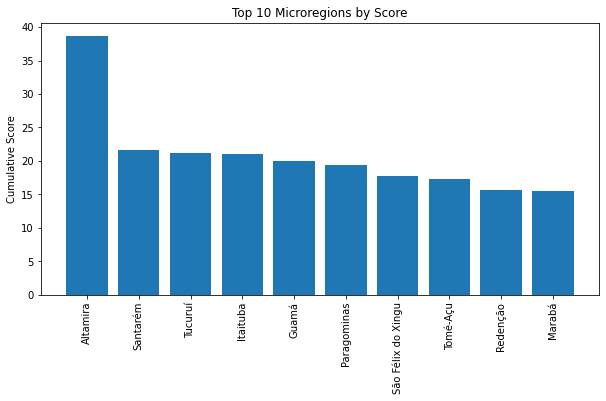

In [11]:
# Select microregions by sum of score
score_reg = np.array(df_avg_productivity[['Microregion', 'Score']].groupby('Microregion').sum().sort_values('Score', ascending=False).head(10).reset_index())
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.bar(range(len(score_reg)), score_reg[:,1])
ax.set_xticks(range(len(score_reg)), score_reg[:,0], rotation=90)
ax.set_ylabel('Cumulative Score')
ax.set_title('Top 10 Microregions by Score')
fig.show();

As can be seen in the graph above, Altamira is by far the most problematic region in this dataset, as it beats the second worst by almost a factor of two.

C:\Users\cadud\AppData\Local\Temp\ipykernel_16556\2115115159.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


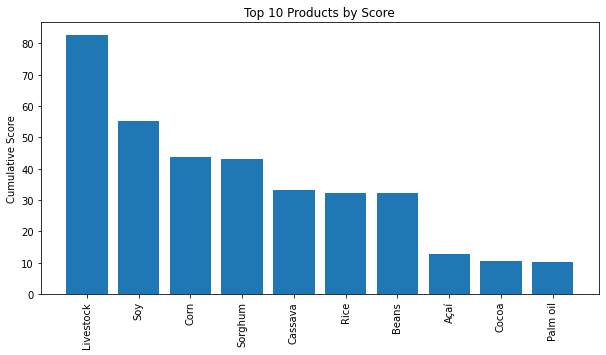

In [17]:
# Select products by sum of score
score_prod = np.array(df_avg_productivity[['Product', 'Score']].groupby('Product').sum().sort_values('Score', ascending=False).head(10).reset_index())
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.bar(range(len(score_prod)), score_prod[:,1])
ax.set_xticks(range(len(score_prod)), score_prod[:,0], rotation=90)
ax.set_ylabel('Cumulative Score')
ax.set_title('Top 10 Products by Score')
fig.show();

And in the product impact graph, Livestock is also a very problematic product-type. Soy is its closest competitor, and lagging close behind that is Corn.